In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from datasets.utils import get_split_indecies
from tools.utils import set_seed
import numpy as np
import h5py

set_seed(1234)

2023-08-13 19:49:02.200489: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-13 19:49:02.233297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 19:49:02.687574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [2]:
from datasets.fabric import make_sigmod_ds, DatasetName

dataset_name = DatasetName.MIGOU_MOD
ds_path = cur_dir + "/data/MIGOU-MOD/MIGOU-MOD_dataset_19.08_400000x128/migou_dataset_19.08_400000x128.pkl"
dataset_path = os.path.abspath(ds_path)
ds = make_sigmod_ds(dataset_name)
ds.load(dataset_path, shuffle=True, normalize=True)
print(f"Modulations: {ds.get_modulations()}")

Loaded 8800000 samples with shape (2, 128)
{'8PSK': 0, 'AM-DSB': 1, 'AM-SSB': 2, 'BPSK': 3, 'CPFSK': 4, 'GFSK': 5, 'PAM4': 6, 'QAM16': 7, 'QAM64': 8, 'QPSK': 9, 'WBFM': 10}
Postprocessed and loaded MIGOU-MOD
Modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']


# Load model

In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results

model_name = "cnn_1d_v012_small_radio_ml16b_normalized"
results = load_results(model_name + "_results/", load_model=True)
model = results["model"]


2023-08-13 19:49:37.053141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-13 19:49:37.152105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-13 19:49:37.152429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Evaluate model

In [4]:
# print(ds.get_data().shape)
# print(ds.get_modulations())
from tqdm import trange
rml2016_modulations = {
    "8PSK": 0,
    "AM-DSB": 1,
    "BPSK": 2,
    "CPFSK": 3,
    "GFSK": 4,
    "PAM4": 5,
    "QAM16": 6,
    "QAM64": 7,
    "QPSK": 8,
    "WBFM": 9,
}
migou_mod_modulations = {mod: i for i, mod in enumerate(ds.get_modulations())}
print(rml2016_modulations)
print(migou_mod_modulations)
rml2016_to_migou_mod_mapping = [migou_mod_modulations[mod] for mod in rml2016_modulations]
print(rml2016_to_migou_mod_mapping)


def predict_func_rml16(model, data, batch_size=512, *args, **kwargs):
    n_samples = data.shape[0]
    pred = np.empty((n_samples, 10), dtype=np.uint8)
    print(n_samples, batch_size)
    for i in trange(int(np.ceil(n_samples / batch_size))):
        first = i * batch_size
        last = min((i + 1) * batch_size, n_samples)
        pred[first:last] = model.predict(data[first:last], verbose=0)
    labels = np.argmax(pred, axis=1)
    labels = np.asarray([rml2016_to_migou_mod_mapping[label] for label in labels])
    return labels

{'8PSK': 0, 'AM-DSB': 1, 'BPSK': 2, 'CPFSK': 3, 'GFSK': 4, 'PAM4': 5, 'QAM16': 6, 'QAM64': 7, 'QPSK': 8, 'WBFM': 9}
{'8PSK': 0, 'AM-DSB': 1, 'AM-SSB': 2, 'BPSK': 3, 'CPFSK': 4, 'GFSK': 5, 'PAM4': 6, 'QAM16': 7, 'QAM64': 8, 'QPSK': 9, 'WBFM': 10}
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
print(np.argmax(model.predict(ds.get_data()[:30]), axis=1))
print(predict_func_rml16(model, ds.get_data()[:30]))
print(ds.get_data()[0].shape)
print(np.min(ds.get_data()[0]))
print(np.max(ds.get_data()[0]))
print(np.mean(ds.get_data()[0]))

print(ds.get_data().shape)
print(np.min(ds.get_data()))
print(np.max(ds.get_data()))
print(np.mean(ds.get_data()))
print(np.std(ds.get_data()))

2023-08-13 19:49:39.414561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 2s 2s/step


2023-08-13 19:49:40.404929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[3 9 9 9 4 9 9 9 9 3 4 9 9 9 9 9 4 9 9 9 9 9 9 9 4 9 4 9 4 4]
30 512


100%|██████████| 1/1 [00:00<00:00, 31.09it/s]


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0
  0  0  0  0  0  0]
(128, 2)
0.030769229
1.0
0.47894633
(8800000, 128, 2)
0.0
1.0
0.4993637
0.30451238


800000 100000


100%|██████████| 8/8 [00:32<00:00,  4.04s/it]


Preds shape: (800000,)
Overall test accuracy: {'Overall': 0.1069625}
8PSK test accuracy: 0.9765601301602184
AM-DSB test accuracy: 0.0
AM-SSB test accuracy: 0.0
BPSK test accuracy: 0.0
CPFSK test accuracy: 0.0
GFSK test accuracy: 0.0
PAM4 test accuracy: 0.0
QAM16 test accuracy: 0.0
QAM64 test accuracy: 0.0
QPSK test accuracy: 0.0
WBFM test accuracy: 0.20244126814131344
Confusion matrix:
[[70826     0     0     0    26     3     0     0     0     0  1671]
 [72433     0     0     0     0     0     0     0     0     0     1]
 [72877     0     0     0     0     0     0     0     1     0    21]
 [71664     0     0     0     6     0     0     0     0     0  1394]
 [71070     0     0     0     0    22     0     0     0     0  2030]
 [41014     0     0     0     0     0     0     0     0     0 31892]
 [72370     0     0     0     0     0     0     0     0     0   352]
 [71567     0     0     0   190     1     0     0     0     0   303]
 [71984     0     0     0   153     1     0     0     0    

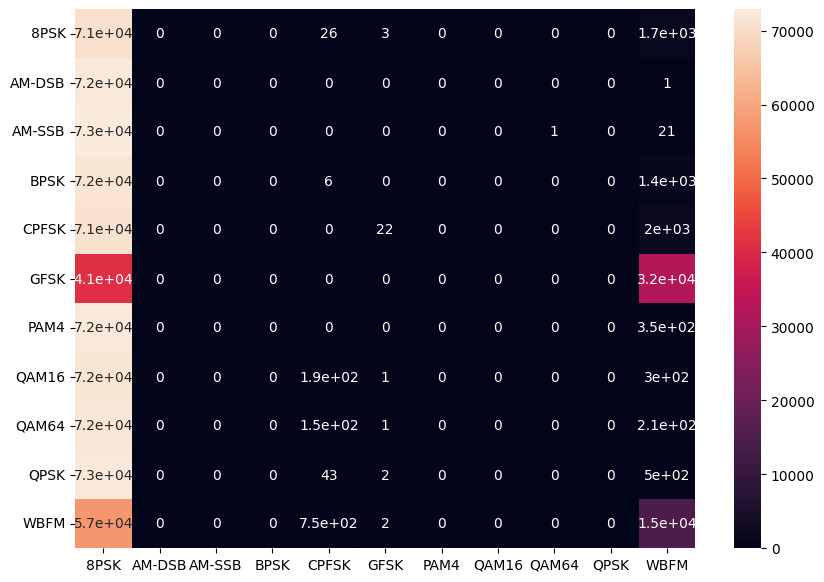

In [6]:
reload_module("evaluation")
from evaluation.metric_evaluation import metric_evaluation

test_size = 800_000

cm, cls_to_acc = metric_evaluation(
    model,
    ds.get_data()[:test_size],
    ds.get_labels()[:test_size],
    ds.get_modulations(),
    predict_func=predict_func_rml16,
    predict_kwargs={"batch_size": 100_000}
)

In [ ]:
from evaluation.metric_evaluation import snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

snr_to_acc = snr_to_metric_evaluation(
    model,
    ds.get_data(),
    ds.get_labels(),
    ds.get_snrs(),
)

plot_snr_to_acc(snr_to_acc)

In [ ]:
# import pickle

# ds_path = "../data/MIGOU-MOD/MIGOU-MOD_dataset_19.08_400000x128/migou_dataset_19.08_400000x128.pkl"
# with open(ds_path, 'rb') as fp:
#     dataset = pickle.load(fp, encoding='latin1')

# all_modulations = np.unique(list(map(lambda x: x[0], dataset.keys())))  # All unique types of modulations
# all_snrs = np.unique(list(map(lambda x: x[1], dataset.keys())))  # All unique values of SNR

# print(all_modulations)
# print(all_snrs)
# print(len(dataset))
# print(len(dataset[('8PSK', 'ota_1m')]))
# print(len(dataset[('8PSK', 'ota_1m')][0]))
# print(np.array(dataset[('8PSK', 'ota_1m')][0]))
# print(np.array(dataset[('8PSK', 'ota_1m')][0].dtype))
# print(np.array(dataset[('8PSK', 'ota_1m')][0].shape))